# 栄養パターンに基づく口腔・上部消化管がん分類モデルの構築および評価４（PCAパターンVer）

In [1]:
%reset -f

# 概要

## パッケージインストール

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
!pip install statsmodels
from statsmodels.duration.hazard_regression import PHReg
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from decimal import Decimal, ROUND_HALF_UP
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, make_scorer
import joblib
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import os
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import io
from contextlib import redirect_stdout
from IPython.display import display
import shap

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データの読み込み

In [3]:
# データの読み込み
adjusted_z_df=pd.read_csv("adjusted_z_df.csv")
pcaDF_TN_proj=pd.read_csv('pcaDF_TN_proj.csv')

In [ ]:
display(pcaDF_TN_proj)

## 学習用データとテスト用データの作成

In [ ]:
xDF_all = pcaDF_TN_proj.drop('TargetName', axis=1)

#Prepare outputs/classes of all samples

yDF_all = pcaDF_TN_proj["TargetName"]

#Check
print('Inputs:')
display(xDF_all)
display(xDF_all.shape)
print('Outputs:')
display(yDF_all)
display(yDF_all.shape)

In [ ]:

#Split the dataset into training and testing sets
xDF_train, xDF_test, yDF_train, yDF_test = train_test_split(xDF_all, yDF_all,
                                                            test_size=0.2, shuffle=True, random_state=123)

#Check the np.array shape
display(xDF_train.shape)
display(xDF_test.shape)
display(yDF_train.shape)
display(yDF_test.shape)
display(xDF_train)
display(yDF_train)

In [7]:
save_dir = '.' 
# ファイルパスの定義
x_file_path = os.path.join(save_dir, 'xDF_test.csv')
y_file_path = os.path.join(save_dir, 'yDF_test.csv')
print("データをCSVファイルに保存します...")
# 1. xDF_test (DataFrame) の保存
xDF_test.to_csv(x_file_path, index=False) 
# 2. yDF_test (Series) の保存
yDF_test.to_csv(y_file_path, index=False, header=True) 
print(f"xDF_test を {x_file_path} に保存しました。")
print(f"yDF_test を {y_file_path} に保存しました。")

データをCSVファイルに保存します...
xDF_test を ./xDF_test.csv に保存しました。
yDF_test を ./yDF_test.csv に保存しました。


In [ ]:
yDF_test.value_counts(dropna=False)

In [ ]:
yDF_train.value_counts(dropna=False)

## ハイパーパラメーターの最適化

In [10]:
n_estimators_space = np.unique([int(x) for x in np.logspace(1, 3, num=7, endpoint=True)])
n_estimators_space = n_estimators_space[n_estimators_space > 0]
# Prepare hyperparameter space to be searched
param_space = {
    'n_estimators': n_estimators_space, 
    'max_depth': [int(i) for i in range(3, 11)],  
    
    'min_samples_leaf': [int(i) for i in np.unique(np.logspace(0, 2, num=10, endpoint=False))], 
    # np.logspace(0, 2, num=10) で 1から100までを対数的に10点でカバー。
    'max_features': ['sqrt', 'log2', 4, 5, 10, 15, 21, 26, 30], 
    # 21で頭打ちの可能性を考慮し、21より大きい値を手動で追加 (例: 26, 30)。
}
#Prepare a model while setting hyperparameters
model = RandomForestClassifier(criterion='gini',
                               #max_depth=None,
                               min_samples_split=2,
                               #min_samples_leaf=1,
                               min_weight_fraction_leaf=0.0,
                               #max_features=None,
                               random_state=123,#Specified for reproducibility
                               max_leaf_nodes=None,
                               min_impurity_decrease=0.0,
                               class_weight='balanced',
                               ccp_alpha=0.0)

#Prepare CV generator
cv_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)#Specified for reproducibility

#Wrap the model for tuning hyperparameters with cross-validation
modelcv = GridSearchCV(model, param_grid=param_space,
                       scoring=None, n_jobs=None, refit=True, cv=cv_gen,
                       verbose=2, pre_dispatch='2*n_jobs', error_score=np.nan, return_train_score=False)

#Fit models with all set of parameters on the training set
modelcv.fit(xDF_train, yDF_train.values.ravel())

#Check the CV results
print('Best score:', modelcv.best_score_)
print('Best hyperparameters:', modelcv.best_params_)
tempDF = pd.DataFrame(modelcv.cv_results_).sort_values('mean_test_score', ascending=False)
display(tempDF)

Fitting 5 folds for each of 5040 candidates, totalling 25200 fits
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=10; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=21; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=21; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=21; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=21; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, 

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1612       0.226334      0.002083         0.002226        0.000021   
1619       0.231131      0.005019         0.002212        0.000014   
901        0.736487      0.003193         0.012820        0.000761   
304        0.242496      0.002881         0.003289        0.000020   
340        0.468490      0.002137         0.006038        0.000078   
...             ...           ...              ...             ...   
3347       0.034268      0.001205         0.001779        0.000470   
3207       0.036420      0.001578         0.001699        0.000170   
4719       0.103749      0.004350         0.001738        0.000085   
2891       0.062902      0.000756         0.001312        0.000026   
4718       0.050696      0.000691         0.001330        0.000017   

      param_max_depth param_max_features  param_min_samples_leaf  \
1612                5                 15                       1   
1619                5                 15                       1   
901                 4                  5                      39   
304                 3                 10                       3   
340                 3                 10                      39   
...               ...                ...                     ...   
3347                8                  4                      39   
3207                8               sqrt                      39   
4719               10                 10                       6   
2891                7                 15                       3   
4718               10                 10                       6   

      param_n_estimators                                             params  \
1612                  46  {'max_depth': 5, 'max_features': 15, 'min_samp...   
1619                  46  {'max_depth': 5, 'max_features': 15, 'min_samp...   
901                  464  {'max_depth': 4, 'max_features': 5, 'min_sampl...   
304                  100  {'max_depth': 3, 'max_features': 10, 'min_samp...   
340                  215  {'max_depth': 3, 'max_features': 10, 'min_samp...   
...                  ...                                                ...   
3347                  21  {'max_depth': 8, 'max_features': 4, 'min_sampl...   
3207                  21  {'max_depth': 8, 'max_features': 'sqrt', 'min_...   
4719                  21  {'max_depth': 10, 'max_features': 10, 'min_sam...   
2891                  10  {'max_depth': 7, 'max_features': 15, 'min_samp...   
4718                  10  {'max_depth': 10, 'max_features': 10, 'min_sam...   

      split0_test_score  split1_test_score  split2_test_score  \
1612           0.524194           0.534413           0.591093   
1619           0.524194           0.534413           0.591093   
901            0.540323           0.546559           0.607287   
304            0.524194           0.530364           0.570850   
340            0.536290           0.566802           0.595142   
...                 ...                ...                ...   
3347           0.447581           0.477733           0.510121   
3207           0.447581           0.477733           0.510121   
4719           0.471774           0.481781           0.514170   
2891           0.443548           0.493927           0.449393   
4718           0.403226           0.489879           0.481781   

      split3_test_score  split4_test_score  mean_test_score  std_test_score  \
1612           0.526316           0.526316         0.540466        0.025554   
1619           0.526316           0.526316         0.540466        0.025554   
901            0.489879           0.502024         0.537214        0.041198   
304            0.514170           0.542510         0.536418        0.019513   
340            0.469636           0.514170         0.536408        0.043189   
...                 ...                ...              ...             ...   
3347           0.473684           0.465587         0.474941      

In [11]:
best_model = modelcv.best_estimator_
filename = 'best_random_forest_None_c_model.joblib'
joblib.dump(best_model, filename)
print(f"最適なモデルを {filename} に保存しました。")

最適なモデルを best_random_forest_None_c_model.joblib に保存しました。


In [12]:
filename = 'best_random_forest_None_c_model.joblib'
model = joblib.load(filename)

## 分類モデルの精度分析

### 分類モデルの精度結果

In [13]:
#Evaluate the model on the testing set, based on classification accuracy
score = model.score(xDF_test, yDF_test)
print('Classification accuracy:', score)

#Predict classes of the testing set
tempA = model.predict(xDF_test)
##Clean
tempS = pd.Series(tempA, index=xDF_test.index, name='PredictedClass')
tempDF = yDF_test.rename('TrueClass') 
tempDF = pd.merge(tempS, tempDF, left_index=True, right_index=True, how='left')

#Check
#display(tempDF)
#display(tempDF.describe(include='all'))
display(tempDF['TrueClass'].value_counts())
display(tempDF['PredictedClass'].value_counts())
display(tempDF.loc[tempDF['TrueClass']!=tempDF['PredictedClass']])

Classification accuracy: 0.5548387096774193


TrueClass
oral_cancer    155
non_cancer     155
Name: count, dtype: int64

PredictedClass
non_cancer     169
oral_cancer    141
Name: count, dtype: int64

PredictedClass    TrueClass
680      non_cancer  oral_cancer
605     oral_cancer   non_cancer
1408    oral_cancer   non_cancer
1294     non_cancer  oral_cancer
1257    oral_cancer   non_cancer
...             ...          ...
597      non_cancer  oral_cancer
1498     non_cancer  oral_cancer
512      non_cancer  oral_cancer
1355    oral_cancer   non_cancer
945     oral_cancer   non_cancer

[138 rows x 2 columns]

### 決定木モデルの一例

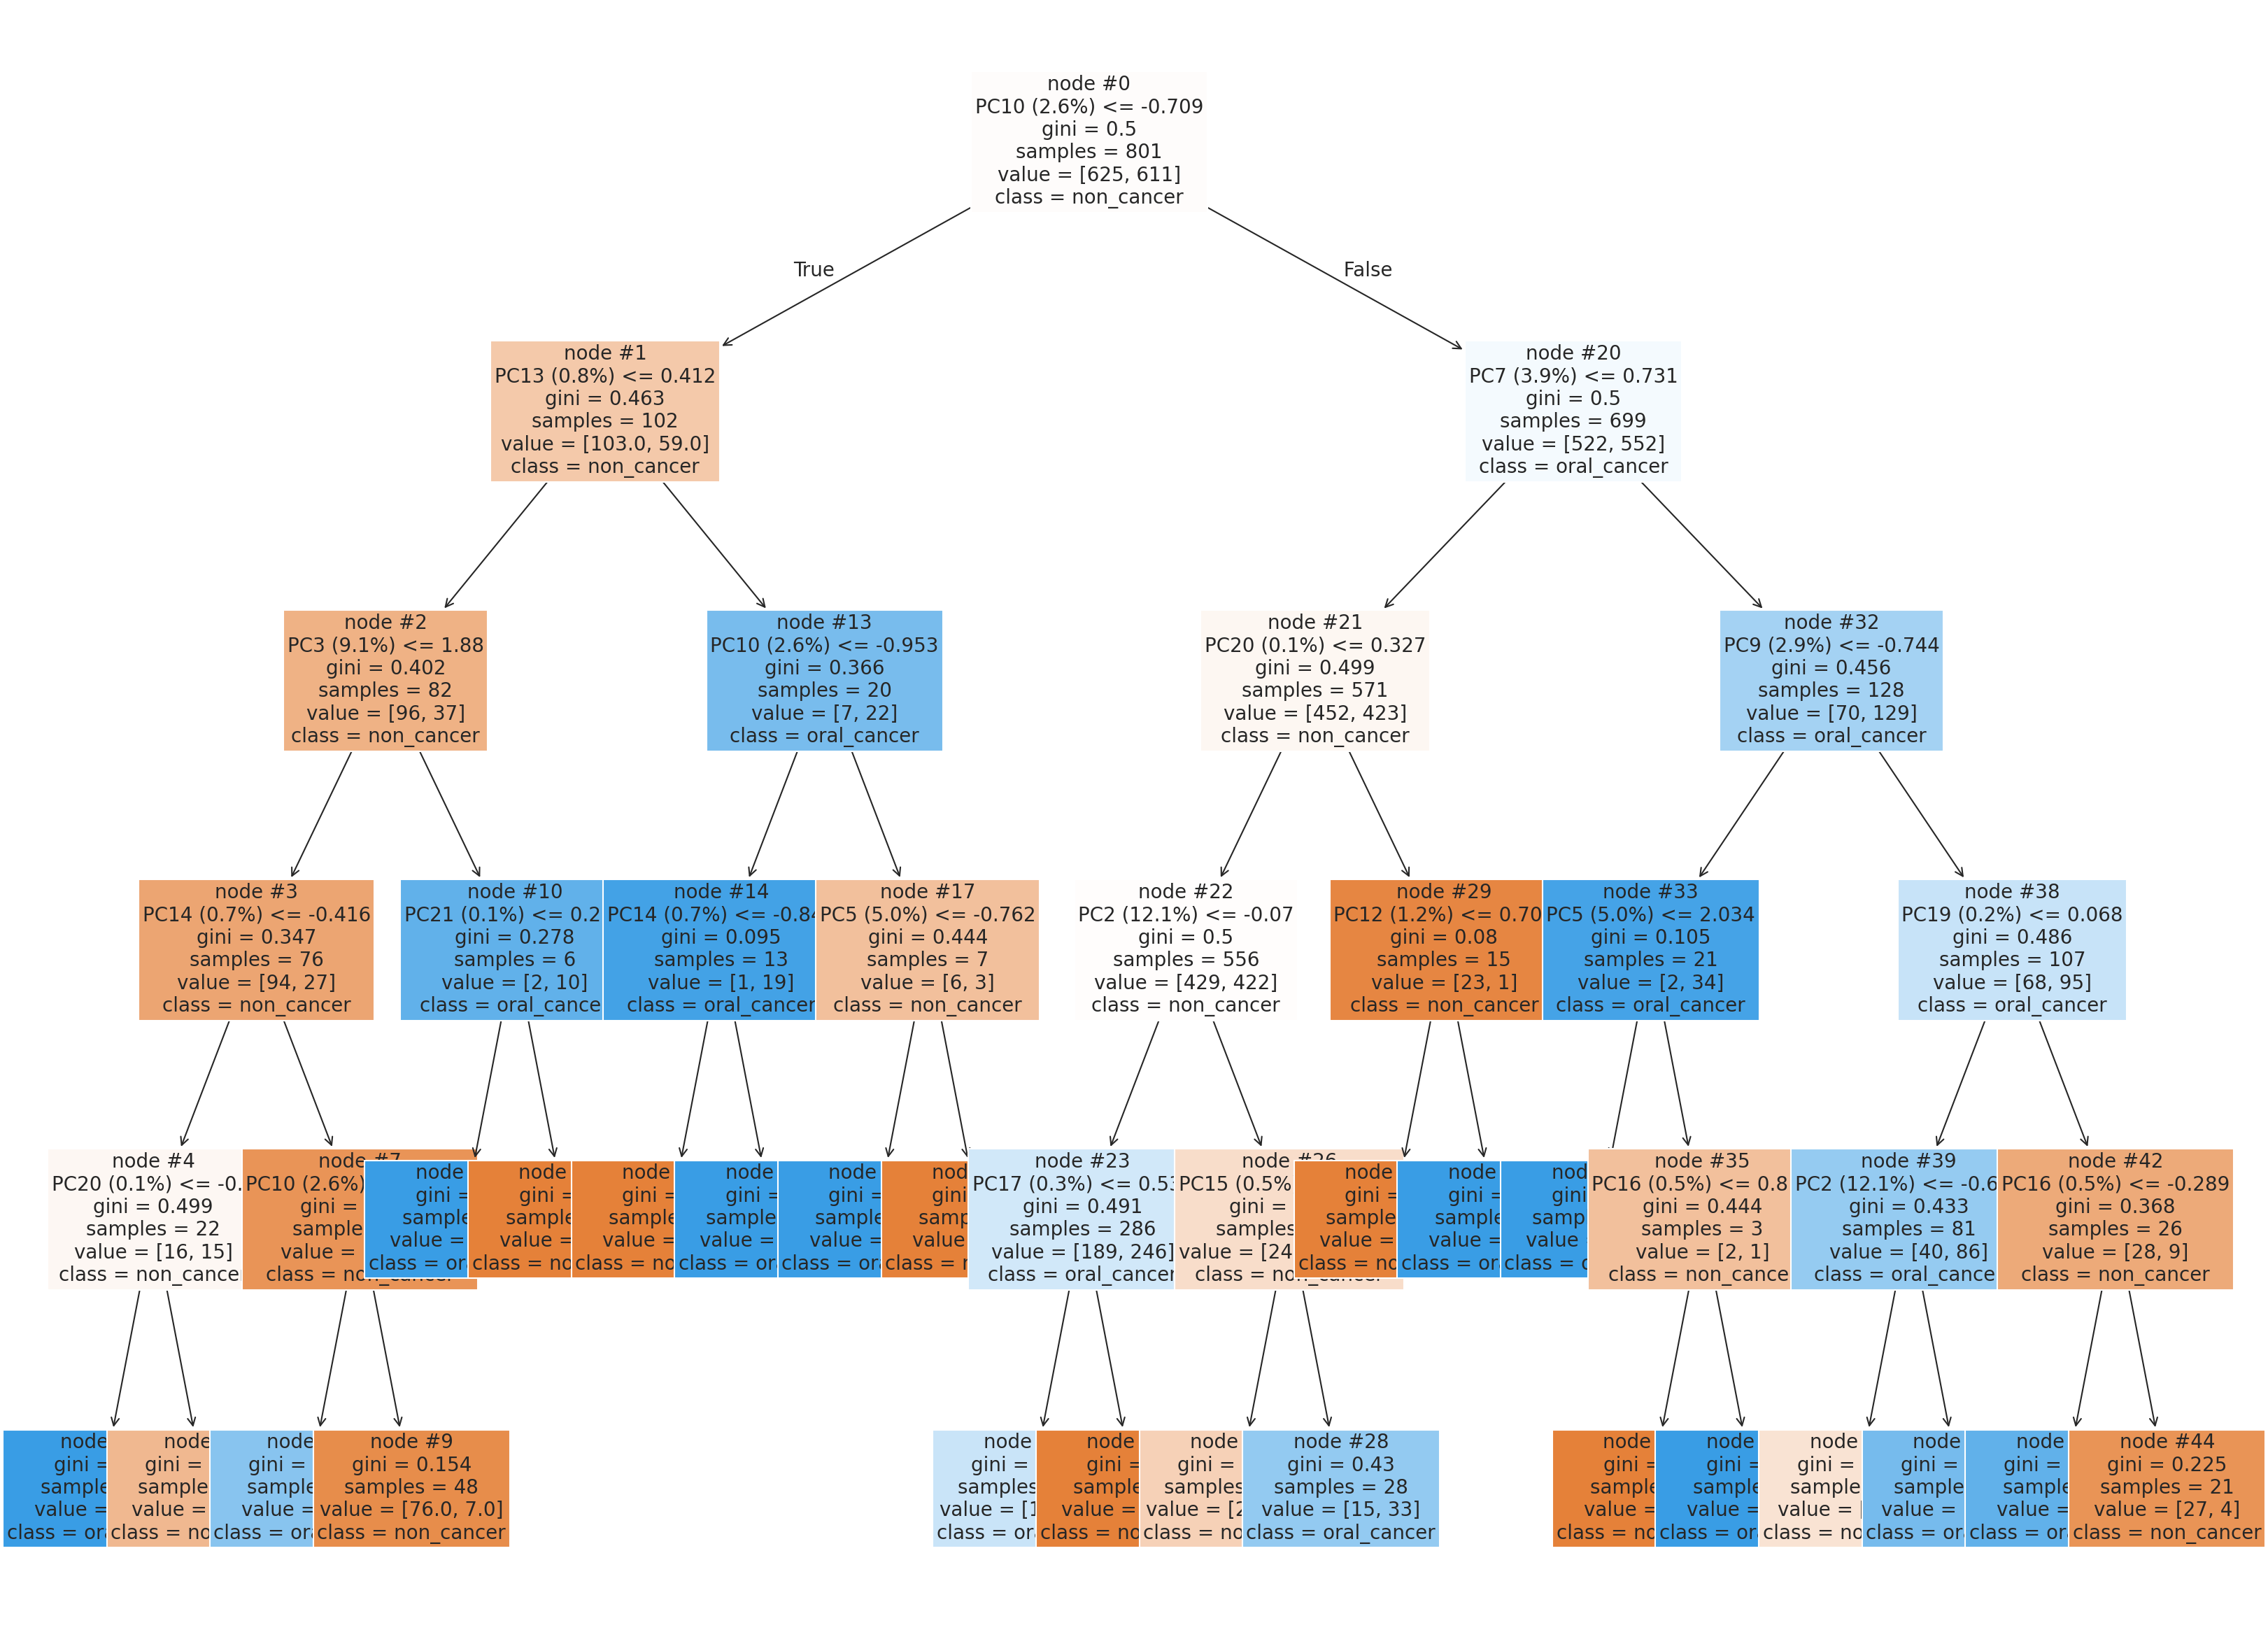

In [14]:
# 1. 学習済みのRandomForestClassifierから、構成要素である単一の決定木を取り出す
sns.set(style='ticks', context='talk')
single_tree = model.estimators_[0]

# 2. 可視化の実行
plt.figure(figsize=(40, 30)) 
plot_tree(
    decision_tree=single_tree,                     
    feature_names=xDF_train.columns.tolist(),      
    class_names=model.classes_.astype(str).tolist(),
    filled=True, 
    node_ids=True,
    fontsize=20
)

plt.show()

###　特徴量の重要度

In [15]:
# 1. 学習済みモデルを best_model と仮定
importance_scores = model.feature_importances_

# 2. xDF_train の列名（特徴量名）を直接使用する
feature_names = xDF_train.columns.tolist() 
# 3. DataFrameの作成 (これでエラーは解消するはずです)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
})

# 4. 重要度が高い順にソートして表示
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(sorted_importance_df)

        Feature  Importance
7    PC8 (3.1%)    0.077893
6    PC7 (3.9%)    0.070609
16  PC17 (0.3%)    0.068791
11  PC12 (1.2%)    0.067805
2    PC3 (9.1%)    0.061587
20  PC21 (0.1%)    0.052053
3    PC4 (6.1%)    0.048923
12  PC13 (0.8%)    0.047352
0   PC1 (45.0%)    0.042707
14  PC15 (0.5%)    0.042104
1   PC2 (12.1%)    0.041666
15  PC16 (0.5%)    0.040798
4    PC5 (5.0%)    0.040443
13  PC14 (0.7%)    0.039895
18  PC19 (0.2%)    0.039189
5    PC6 (4.0%)    0.038783
9   PC10 (2.6%)    0.037622
17  PC18 (0.3%)    0.036676
8    PC9 (2.9%)    0.036664
19  PC20 (0.1%)    0.035159
10  PC11 (1.6%)    0.033282


### 混同行列

In [16]:

y_pred = model.predict(xDF_test)
print(classification_report(yDF_test.values.ravel(), y_pred)) # 再現率、適合率、F1スコアなどを確認

              precision    recall  f1-score   support

  non_cancer       0.55      0.60      0.57       155
 oral_cancer       0.56      0.51      0.53       155

    accuracy                           0.55       310
   macro avg       0.56      0.55      0.55       310
weighted avg       0.56      0.55      0.55       310




✅ 全てのテキスト出力は "PCA_model_evaluation_report.txt" に保存されました。
✅ Classification Report のDataFrameは "PCA_classification_report_df.csv" にCSVとして保存されました。
✅ 混同行列のグラフは "PCA_confusion_matrix.png" にPNG画像として保存されました。


--- 実行結果の確認 (画面表示) ---
Accuracy: 0.5548387096774193
-> Cf. Manual calculation: 0.5548387096774193


Classification Report (DataFrame T):


precision    recall  f1-score     support
non_cancer     0.550296  0.600000  0.574074  155.000000
oral_cancer    0.560284  0.509677  0.533784  155.000000
accuracy       0.554839  0.554839  0.554839    0.554839
macro avg      0.555290  0.554839  0.553929  310.000000
weighted avg   0.555290  0.554839  0.553929  310.000000

<Figure size 600x400 with 0 Axes>

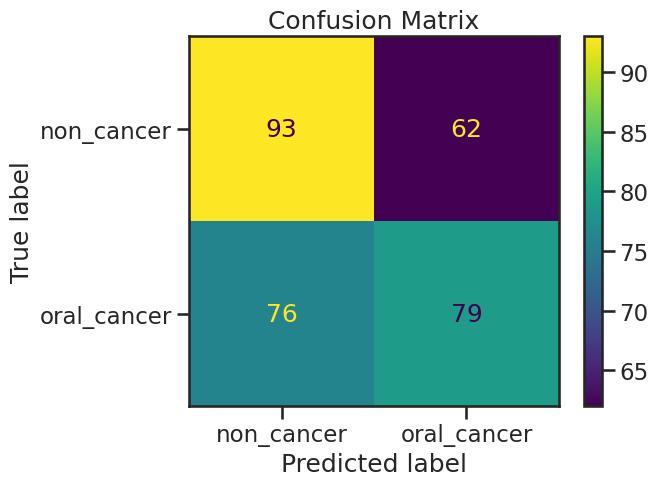

In [17]:
y_pred = model.predict(xDF_test)
tempDF_true = yDF_test.rename('TrueClass') 
tempS_pred = pd.Series(y_pred, index=xDF_test.index, name='PredictedClass')
# 結合して最終的な評価用DataFrame (tempDF) を作成
tempDF = pd.merge(tempS_pred, tempDF_true, left_index=True, right_index=True, how='left')
TEXT_OUTPUT_FILENAME = 'PCA_model_evaluation_report.txt'
CLASSIFICATION_REPORT_DF_FILENAME = 'PCA_classification_report_df.csv'

# バッファを用意し、print出力をリダイレクト
f = io.StringIO()
with redirect_stdout(f):
    print('--- モデル評価結果 ---')
    print()
    # Accuracy
    accuracy = accuracy_score(tempDF['TrueClass'], tempDF['PredictedClass'], normalize=True)
    print('Accuracy:', accuracy)
    # Cf. Manual calculation (手動計算)
    manual_accuracy = (tempDF['TrueClass']==tempDF['PredictedClass']).sum()/len(tempDF)
    print('-> Cf. Manual calculation:', manual_accuracy)

    print('\n' + '='*30 + '\n')

    ## 混同行列の表示 (ここでは表示はスキップし、画像で保存する)
    print('## 混同行列の表示')
    print('Confusion Matrix (グラフ) は ' + 'PCA_confusion_matrix.png' + ' に保存されます。')

    print('\n' + '='*30 + '\n')

    ## Precision, Recall, F1-score の DataFrame 出力
    tempD = classification_report(tempDF['TrueClass'], tempDF['PredictedClass'], output_dict=True)

    # 辞書をDataFrameに変換
    report_df = pd.DataFrame(tempD).T

    # 最終レポートDataFrameをCSVとして保存
    report_df.to_csv(CLASSIFICATION_REPORT_DF_FILENAME, float_format='%.4f')
    print(f'Classification Report (DataFrame T) は {CLASSIFICATION_REPORT_DF_FILENAME} にCSVとして保存されました。')
    print('\nClassification Report (DataFrame T) の内容:')
    # print関数でDataFrameの内容をファイルに書き込み
    print(report_df.to_string()) # to_string()で整形されたテキスト形式に変換して出力

# リダイレクトされた出力をファイルに書き込み
with open(TEXT_OUTPUT_FILENAME, 'w', encoding='utf-8') as text_file:
    text_file.write(f.getvalue())

print(f'\n✅ 全てのテキスト出力は "{TEXT_OUTPUT_FILENAME}" に保存されました。')
print(f'✅ Classification Report のDataFrameは "{CLASSIFICATION_REPORT_DF_FILENAME}" にCSVとして保存されました。')

CONFUSION_MATRIX_FILENAME = 'PCA_confusion_matrix.png'
plt.figure(figsize=(6,4)) 
# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(tempDF['TrueClass'], tempDF['PredictedClass'])
plt.title('Confusion Matrix') 
# plt.show() の代わりに plt.savefig() でファイルに保存
plt.savefig(CONFUSION_MATRIX_FILENAME, bbox_inches='tight')
plt.close()

print(f'✅ 混同行列のグラフは "{CONFUSION_MATRIX_FILENAME}" にPNG画像として保存されました。')

print('\n\n--- 実行結果の確認 (画面表示) ---')
print('Accuracy:', accuracy)
print('-> Cf. Manual calculation:', manual_accuracy)
print('\n' + '='*30 + '\n')
print('Classification Report (DataFrame T):')
display(report_df)
ConfusionMatrixDisplay.from_predictions(tempDF['TrueClass'], tempDF['PredictedClass'])
plt.title('Confusion Matrix')
plt.show()

### ROC曲線

--- ROC曲線とAUCの計算 ---


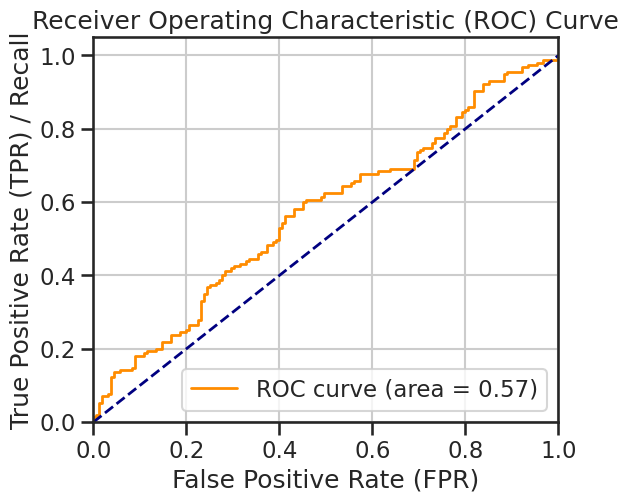


AUC (Area Under the Curve): 0.5713




In [18]:
print('--- ROC曲線とAUCの計算 ---')
# 1. 予測確率の取得
y_score = model.predict_proba(xDF_test)

# 2. 正解ラベルの準備 (二値化)
ptnA={'non_cancer':0,'oral_cancer':1}
yDF_test=yDF_test.map(ptnA)
y_true_binary = yDF_test.values.ravel() 

# 3. ROC曲線の計算
fpr, tpr, thresholds = roc_curve(y_true_binary, y_score[:, 1])
roc_auc = auc(fpr, tpr)

# 4. ROC曲線のプロット
plt.figure(figsize=(6, 5))

# ROC曲線のプロット
plt.plot(
    fpr, tpr, color='darkorange', lw=2, 
    label=f'ROC curve (area = {roc_auc:0.2f})'
)

# ランダムな分類器の対角線 (AUC=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# グラフの設定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)') # 偽陽性率
plt.ylabel('True Positive Rate (TPR) / Recall') # 真陽性率 / 再現率
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f'\nAUC (Area Under the Curve): {roc_auc:.4f}')
print('\n' + '='*30 + '\n')

### SHAP値出力

--- SHAP Based Feature Importance (Mean Absolute SHAP Value) ---
        Feature  SHAP_Importance
6    PC7 (3.9%)         0.021810
11  PC12 (1.2%)         0.018642
7    PC8 (3.1%)         0.015525
16  PC17 (0.3%)         0.013771
2    PC3 (9.1%)         0.011727
20  PC21 (0.1%)         0.009445
17  PC18 (0.3%)         0.008522
18  PC19 (0.2%)         0.006768
3    PC4 (6.1%)         0.006537
14  PC15 (0.5%)         0.006509
1   PC2 (12.1%)         0.006436
5    PC6 (4.0%)         0.006321
10  PC11 (1.6%)         0.005764
9   PC10 (2.6%)         0.005462
0   PC1 (45.0%)         0.005041
12  PC13 (0.8%)         0.004177
13  PC14 (0.7%)         0.003976
4    PC5 (5.0%)         0.003824
15  PC16 (0.5%)         0.003690
19  PC20 (0.1%)         0.003466
8    PC9 (2.9%)         0.003425

--- SHAP Summary Plot ---


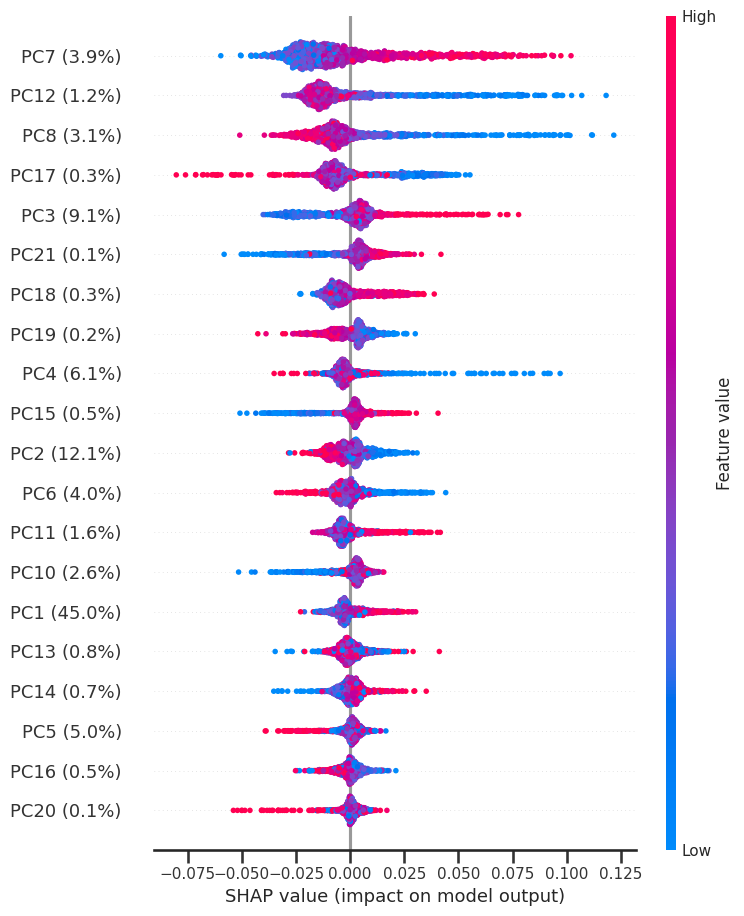

In [19]:
# 0. SHAP JavaScriptの初期化 
shap.initjs()
# 1. SHAP Explainer の作成 
explainer = shap.TreeExplainer(model)
# 2. SHAP値の計算 (実行済み)
shap_values = explainer.shap_values(xDF_train) 
# 適切なSHAP値の抽出 (クラス1のSHAP値)
shap_values_class1 = shap_values[:, :, 1]
# 3. 特徴量のグローバルな重要度 (Mean Absolute SHAP Value) の計算 (修正)
shap_v = np.abs(shap_values_class1).mean(axis=0)
# 4. DataFrameの作成 (特徴量名と重要度を結合) (修正なし)
feature_names = xDF_train.columns.tolist()

shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': shap_v
})

# 5. 重要度が高い順にソートして表示
sorted_shap_importance_df = shap_importance_df.sort_values(by='SHAP_Importance', ascending=False)
print("--- SHAP Based Feature Importance (Mean Absolute SHAP Value) ---")
print(sorted_shap_importance_df)


# 6. SHAP Summary Plotの表示
print("\n--- SHAP Summary Plot ---")
shap.summary_plot(shap_values_class1, xDF_train)

In [20]:
shap.initjs()
# 1. SHAP Explainer の作成 
explainer = shap.TreeExplainer(model)
# 2. SHAP値の計算 (実行済み)
shap_values = explainer.shap_values(xDF_train) 
# 適切なSHAP値の抽出 (クラス1のSHAP値)
shap_values_class1 = shap_values[:, :, 1]
# 3. 特徴量のグローバルな重要度 (Mean Absolute SHAP Value) の計算
shap_v = np.abs(shap_values_class1).mean(axis=0)
# 4. DataFrameの作成 
feature_names = xDF_train.columns.tolist()
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': shap_v
})
# 5. 重要度が高い順にソートして表示
sorted_shap_importance_df = shap_importance_df.sort_values(by='SHAP_Importance', ascending=False)
print("--- SHAP Based Feature Importance (Mean Absolute SHAP Value) ---")
print(sorted_shap_importance_df)

csv_filename = 'PCA_shap_feature_importance.csv'
sorted_shap_importance_df.to_csv(csv_filename, index=False)
print(f"\n✅ 特徴量の重要度データを '{csv_filename}' に保存しました。")
# 6. SHAP Summary Plotの表示と保存
print("\n--- SHAP Summary Plotの保存 ---")
shap.summary_plot(shap_values_class1, xDF_train, show=False)
# プロットをファイルとして保存
plot_filename = 'PCA_shap_summary_plot_class1.png'
plt.savefig(plot_filename, bbox_inches='tight') 
plt.close()

print(f"\n✅ SHAP Summary Plotを '{plot_filename}' に保存しました。")

--- SHAP Based Feature Importance (Mean Absolute SHAP Value) ---
        Feature  SHAP_Importance
6    PC7 (3.9%)         0.021810
11  PC12 (1.2%)         0.018642
7    PC8 (3.1%)         0.015525
16  PC17 (0.3%)         0.013771
2    PC3 (9.1%)         0.011727
20  PC21 (0.1%)         0.009445
17  PC18 (0.3%)         0.008522
18  PC19 (0.2%)         0.006768
3    PC4 (6.1%)         0.006537
14  PC15 (0.5%)         0.006509
1   PC2 (12.1%)         0.006436
5    PC6 (4.0%)         0.006321
10  PC11 (1.6%)         0.005764
9   PC10 (2.6%)         0.005462
0   PC1 (45.0%)         0.005041
12  PC13 (0.8%)         0.004177
13  PC14 (0.7%)         0.003976
4    PC5 (5.0%)         0.003824
15  PC16 (0.5%)         0.003690
19  PC20 (0.1%)         0.003466
8    PC9 (2.9%)         0.003425

✅ 特徴量の重要度データを 'PCA_shap_feature_importance.csv' に保存しました。

--- SHAP Summary Plotの保存 ---

✅ SHAP Summary Plotを 'PCA_shap_summary_plot_class1.png' に保存しました。
